<a href="https://colab.research.google.com/github/JUICEMAN123/Music-Generation-Variety/blob/main/Music%20Generation%20with%20GANs%20and%205x5%20kernels%20V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pretty_midi

In [ ]:
import os
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import pretty_midi
from PIL import Image
import matplotlib.pyplot as plt

import time
import logging
import pathlib
from tqdm.autonotebook import tqdm
import pandas as pd

from IPython import display

In [ ]:
tf.version.VERSION

'2.6.0'

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [ ]:
# path = '/content/drive/MyDrive/maestro-v3.0.0-midi/maestro-v3.0.0/2018'
path = '/content/drive/MyDrive/maestro-v3.0.0-midi/maestro-v3.0.0'

# os.chdir(path)
# midi_paths = []
# for fn in os.listdir():
#   midi_paths.append(path+'/'+fn)

os.chdir(path)
midi_paths = []
for folder in os.listdir():
  newpath = path+'/'+folder
  if os.path.isdir(newpath):
    os.chdir(newpath)
    for fn in os.listdir():
      midi_paths.append(newpath+'/'+fn)

In [ ]:
new_dir = '/content/drive/MyDrive/maestro_midi_images/'

In [ ]:
FS = 10
min_note = 21
max_note = 101
img_dims = max_note - min_note

img_dims

80

In [ ]:
def midi2proll(filename):
  midi_pretty_format = pretty_midi.PrettyMIDI(filename)
  midi_piano = midi_pretty_format.instruments[0]
  midi_piano_roll = midi_piano.get_piano_roll(fs=FS)
  return midi_piano_roll # returns piano roll in format (128 notes, time)

def proll2midi(proll):
  notes, frames = proll.shape
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=0)

  proll = np.pad(proll, [(0, 0), (1, 1)], 'constant')
  velocity_changes = np.nonzero(np.diff(proll).T)

  prev_velocities = np.zeros(notes, dtype=int)
  note_on_time = np.zeros(notes)

  for time, note in zip(*velocity_changes):
      velocity = proll[note, time + 1]
      time = time / FS
      if velocity > 0:
          if prev_velocities[note] == 0:
              note_on_time[note] = time
              prev_velocities[note] = velocity
      else:
          pm_note = pretty_midi.Note(
              velocity=prev_velocities[note],
              pitch=note,
              start=note_on_time[note],
              end=time)
          instrument.notes.append(pm_note)
          prev_velocities[note] = 0
  pm.instruments.append(instrument)
  return pm

def proll2img(proll, show=False):
  im = Image.fromarray(np.uint8(proll))
  if show:
    plt.imshow(np.asarray(im), aspect='auto', cmap='gray')
  return im

def img2proll(img, show=False):
  return np.asarray(img)

In [ ]:
def reorganize(proll):
  proll = proll[min_note:max_note]
  chops = np.asarray(np.arange(img_dims, len(proll[0]), img_dims))
  proll_chunks = np.split(proll, chops, axis=1)
  return proll_chunks[:-1]

def reorganize_all(filepaths):
  all_proll_chunks = []
  for fp in filepaths:
    all_proll_chunks.append(reorganize(midi2proll(fp)))
  all_proll_chunks = np.concatenate(all_proll_chunks, axis=0)
  return all_proll_chunks

# proll = midi2proll(midi_paths[5])
# proll_chunks = reorganize(proll)
# img = proll2img(proll_chunks[0], show=True)

In [ ]:
all_data = reorganize_all(midi_paths[:250])
all_data = all_data[..., np.newaxis]
all_data = np.float32(all_data)
print(np.shape(all_data))

(15255, 80, 80, 1)


In [ ]:
TOTAL_SIZE = np.shape(all_data)[0]
BATCH_SIZE = 128
N_TRAIN_BATCHES = int(TOTAL_SIZE/BATCH_SIZE)
N_TEST_BATCHES = int(N_TRAIN_BATCHES * 0.15)

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(all_data)
    .cache()
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = train_dataset.take(N_TEST_BATCHES).shuffle(10000)

# MODEL

In [ ]:
noise_dim = 256

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(5*5*512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((5, 5, 512)))

    model.add(layers.Conv2DTranspose(512, (9, 9), strides=(1, 1), padding='same', use_bias=False)) # (batch_size, 5, 5, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (9, 9), strides=(2, 2), padding='same', use_bias=False)) # (batch_size, 10, 10, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (9, 9), strides=(2, 2), padding='same', use_bias=False)) # (batch_size, 20, 20, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (9, 9), strides=(2, 2), padding='same', use_bias=False)) # (batch_size, 40, 40, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (9, 9), strides=(2, 2), padding='same', use_bias=False)) # (batch_size, 80, 80, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (9, 9), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')) # (batch_size, 80, 80, 1)

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12800)             3276800   
_________________________________________________________________
batch_normalization_12 (Batc (None, 12800)             51200     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 12800)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 5, 512)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 5, 5, 512)         21233664  
_________________________________________________________________
batch_normalization_13 (Batc (None, 5, 5, 512)         2048      
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 5, 5, 512)        

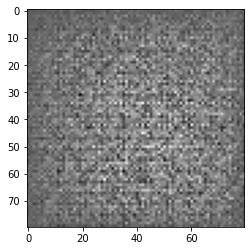

In [ ]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, (9, 9), strides=(1, 1), padding='same', input_shape=[80, 80, 1])) # (batch_size, 80, 80, 64)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (9, 9), strides=(2, 2), padding='same'))  # (batch_size, 40, 40, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (9, 9), strides=(2, 2), padding='same'))  # (batch_size, 20, 20, 256)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (9, 9), strides=(2, 2), padding='same'))  # (batch_size, 10, 10, 512)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (9, 9), strides=(2, 2), padding='same'))  # (batch_size, 5, 5, 1024)
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 80, 80, 32)        2624      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 80, 80, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 64)        165952    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 40, 40, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 128)      

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00880228]], shape=(1, 1), dtype=float32)


In [ ]:
class WGAN(tf.keras.Model):
  def __init__(self, **kwargs):
    super(WGAN, self).__init__()
    self.__dict__.update(kwargs)

  def generate(self, x):
    return self.gen(x)

  def discriminate(self, x):
    return self.disc(x)

  def real_images_noise_regularization(self, real_images):
    noise = tf.random.normal(tf.shape(real_images), stddev=0.15)
    return real_images + noise


  def compute_loss(self, real_images):
    real_images = self.real_images_noise_regularization(real_images)

    z_noise = tf.random.normal((tf.shape(real_images)[0], noise_dim))
    fake_images = self.generate(z_noise)

    real_logits = self.discriminate(real_images)
    fake_logits = self.discriminate(fake_images)

    d_regularizer = self.gradient_penalty(real_images, fake_images)

    real_loss = tf.reduce_mean(real_logits)
    fake_loss = tf.reduce_mean(fake_logits)
    d_regularizer_loss = d_regularizer * self.gradient_penalty_weight
    
    gen_loss = fake_loss
    disc_loss = real_loss - fake_loss + d_regularizer_loss
    
    return gen_loss, disc_loss

  def compute_gradients(self, x):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_loss, disc_loss = self.compute_loss(x)
    
    gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
    
    return gen_gradients, disc_gradients

  def apply_gradients(self, gen_grad, disc_grad):
    self.gen_optimizer.apply_gradients(zip(gen_grad, self.gen.trainable_variables))
    self.disc_optimizer.apply_gradients(zip(disc_grad, self.disc.trainable_variables))

  def gradient_penalty(self, real_images, fake_images):
    epsilon = tf.random.uniform([tf.shape(real_images)[0], 1, 1, 1], 0.0, 1.0)
    x_hat = epsilon * real_images + (1 - epsilon) * fake_images
    with tf.GradientTape() as tape:
      tape.watch(x_hat)
      d_hat = self.discriminate(x_hat)
    gradients = tape.gradient(d_hat, x_hat)
    ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis = [1, 2]))
    d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
    return d_regularizer

  @tf.function
  def train(self, train_x):
    gen_gradients, disc_gradients = self.compute_gradients(train_x)
    self.apply_gradients(gen_gradients, disc_gradients)

In [ ]:
# generator_optimizer = tf.keras.optimizers.Adam(0.0005, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

generator_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5) # maybe try gen=0.0003 and disc=0.0008 WORKS
discriminator_optimizer = tf.keras.optimizers.RMSprop(0.0005) # maybe try gen=0.0001 and disc=0.0005 TESTING

model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = generator_optimizer,
    disc_optimizer = discriminator_optimizer,
    gradient_penalty_weight = 1111.0 # 1000 works # we should try more and less. it may be possible that 
)

In [ ]:
model.compile()

In [ ]:
def draw_example():
  noise = tf.random.normal([1, noise_dim])
  generated_image = generator(noise, training=False)
  plt.imshow(generated_image[0, :, :, 0], cmap='gray')

noise = [tf.random.normal([1, noise_dim]) for _ in range(5)]

def draw_save_example(count=1, keep_noise=True):
  target_dir = new_dir
  if count > 1:
    target_dir = target_dir + str(len(os.listdir(target_dir))) + '/'
    !mkdir {target_dir}
  for i in range(count):
    if keep_noise:
      this_noise = noise[i]
    else: 
      this_noise = tf.random.normal([1, noise_dim])
    generated_image = generator(this_noise, training=False)
    # generated_image = 1 - generated_image
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    generated_image = generated_image[0, :, :, 0]
    generated_image *= 64
    proll2midi(img2proll(generated_image)).write(target_dir + str(len(os.listdir(target_dir))) + '.mid')

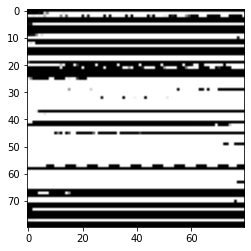

In [ ]:
draw_save_example()

In [ ]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
loss = []

In [ ]:
%cd /content

/content


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0 | disc_loss: -35.37508010864258 | gen_loss: -699.4173583984375


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1 | disc_loss: -31.361913681030273 | gen_loss: -930.9095458984375


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2 | disc_loss: 3.8991849422454834 | gen_loss: -752.1947631835938


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 3 | disc_loss: -4.106934547424316 | gen_loss: -885.0706176757812


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 4 | disc_loss: -5.737281799316406 | gen_loss: -892.8526000976562


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 5 | disc_loss: -14.034099578857422 | gen_loss: -845.7592163085938


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 6 | disc_loss: -12.739133834838867 | gen_loss: -908.3486938476562


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 7 | disc_loss: -14.861953735351562 | gen_loss: -961.5831298828125


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 8 | disc_loss: -45.41108703613281 | gen_loss: -925.4558715820312


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 9 | disc_loss: -43.22461700439453 | gen_loss: -962.6544189453125


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 10 | disc_loss: -43.96997833251953 | gen_loss: -989.8220825195312


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 11 | disc_loss: -44.63924026489258 | gen_loss: -1017.1652221679688


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 12 | disc_loss: -37.333675384521484 | gen_loss: -1043.482666015625


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 13 | disc_loss: -36.5709342956543 | gen_loss: -1045.8846435546875


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 14 | disc_loss: -35.21278381347656 | gen_loss: -1059.839111328125


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 15 | disc_loss: -35.9567756652832 | gen_loss: -1064.6343994140625


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 16 | disc_loss: -38.085731506347656 | gen_loss: -1083.157958984375


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 17 | disc_loss: -39.24617004394531 | gen_loss: -1097.5701904296875


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 18 | disc_loss: -41.11711502075195 | gen_loss: -1107.4193115234375


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 19 | disc_loss: -37.598758697509766 | gen_loss: -1108.0537109375


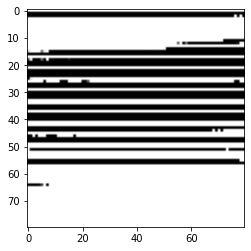

In [ ]:
n_epochs = 20

for epoch in range(n_epochs):
    for batch, train_x in tqdm(zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES):
      model.train(train_x)
    for batch, test_x in tqdm(zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES):
      loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    draw_save_example(5)

    generator.save_weights(f'drive/MyDrive/maestro_midi_image_models/gen_{epoch}')
    discriminator.save_weights(f'drive/MyDrive/maestro_midi_image_models/disc_{epoch}')

    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )

    